<a href="https://colab.research.google.com/github/alexandre-pinon/voltron/blob/master/src/ai/voltron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<header align="center">
  <h1>* T-MAJ *</h1>
  <h1>~ Voltron ~</h1>
  <p>
    <i>Alexandre.D | Alexandre.P | Bastien.F</i>
  </p>
  <img src="https://images.unsplash.com/photo-1499346030926-9a72daac6c63?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1170&q=80" alt="air img"/>
  <h2>Daily climate time series analysis</h2>
</header>

# Setup

## Imports

In [1]:
!git clone https://github.com/alexandre-pinon/voltron.git

Cloning into 'voltron'...
remote: Enumerating objects: 321, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (187/187), done.
remote: Total 321 (delta 122), reused 320 (delta 121), pack-reused 0
Receiving objects: 100% (321/321), 8.39 MiB | 17.12 MiB/s, done.
Resolving deltas: 100% (122/122), done.


In [2]:
!cp -r voltron/src/ai/* .

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

import helpers

In [80]:
import importlib
importlib.reload(helpers)

<module 'helpers' from '/content/helpers.py'>

## Constants

In [4]:
TRAIN_SIZE = 0.8
VAL_SIZE = 0.1
TEST_SIZE = 0.1
EPOCHS = 100
BATCH_SIZE = 128
SEED = 5

## Load data

In [5]:
# Parse dates and set date column to index
train_df = pd.read_csv("./data/DailyDelhiClimateTrain.csv",
                       parse_dates=["date"],
                       index_col=["date"])
test_df = pd.read_csv("./data/DailyDelhiClimateTest.csv",
                      parse_dates=["date"],
                      index_col=["date"])
print(f"Initial train size: {train_df.shape[0]}")
print(f"Initial test size: {test_df.shape[0]}")
print(f"Initial ratio: {(test_df.shape[0] / train_df.shape[0]):.2f}")

Initial train size: 1462
Initial test size: 114
Initial ratio: 0.08


In [6]:
df = pd.concat([train_df, test_df])
train_df = df.iloc[:int((1 - TEST_SIZE) * df.shape[0])]
test_df = df.iloc[int((1 - TEST_SIZE) * df.shape[0]):]
print(f"Updated train size: {train_df.shape[0]}")
print(f"Updated test size: {test_df.shape[0]}")
print(f"Updated ratio: {(test_df.shape[0] / train_df.shape[0]):.2f}")

Updated train size: 1418
Updated test size: 158
Updated ratio: 0.11


# EDA

## Plot values

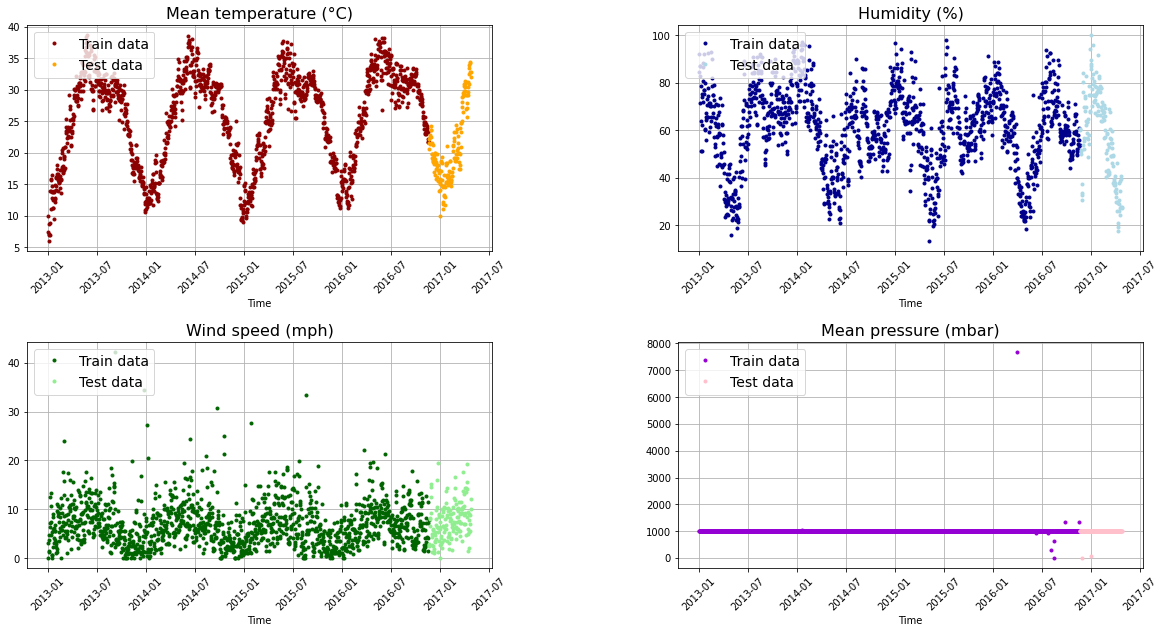

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,
                                             2,
                                             figsize=(20, 10),
                                             gridspec_kw={
                                                 'wspace': .4,
                                                 'hspace': .4
                                             })

helpers.plot_time_series(ax1,
                         train_df.index,
                         train_df["meantemp"],
                         "Mean temperature (°C)",
                         label='Train data',
                         c='darkred')
helpers.plot_time_series(ax1,
                         test_df.index,
                         test_df["meantemp"],
                         "Mean temperature (°C)",
                         label='Test data',
                         c='orange')
helpers.plot_time_series(ax2,
                         train_df.index,
                         train_df["humidity"],
                         "Humidity (%)",
                         label='Train data',
                         c='darkblue')
helpers.plot_time_series(ax2,
                         test_df.index,
                         test_df["humidity"],
                         "Humidity (%)",
                         label='Test data',
                         c='lightblue')
helpers.plot_time_series(ax3,
                         train_df.index,
                         train_df["wind_speed"],
                         "Wind speed (mph)",
                         label='Train data',
                         c='darkgreen')
helpers.plot_time_series(ax3,
                         test_df.index,
                         test_df["wind_speed"],
                         "Wind speed (mph)",
                         label='Test data',
                         c='lightgreen')
helpers.plot_time_series(ax4,
                         train_df.index,
                         train_df["meanpressure"],
                         "Mean pressure (mbar)",
                         label='Train data',
                         c='darkviolet')
helpers.plot_time_series(ax4,
                         test_df.index,
                         test_df["meanpressure"],
                         "Mean pressure (mbar)",
                         label='Test data',
                         c='pink')

# fig.savefig('./graphs/train_plus_test_data.png', facecolor='white')

## Remove outliers

In [19]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1576.000000,1576.000000,1576.000000,1576.000000
mean,25.221918,60.445229,6.899262,1010.593178
std,7.345014,16.979994,4.510725,175.242704
min,6.000000,13.428571,0.000000,-3.041667
25%,18.500000,49.750000,3.700000,1001.875000
50%,27.166667,62.440476,6.363571,1009.055556
75%,31.142857,72.125000,9.262500,1015.200000
max,38.714286,100.000000,42.220000,7679.333333


In [7]:
clf = IsolationForest(contamination=6e-3, random_state=SEED)
clf.fit(df['meanpressure'].to_numpy().reshape(-1,1))
outliers = clf.predict(df['meanpressure'].to_numpy().reshape(-1,1)) == -1

In [8]:
df['meanpressure'].replace(to_replace=df['meanpressure'][outliers].to_numpy(),
                           value=df['meanpressure'].mean(),
                           inplace=True)


In [22]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1576.000000,1576.000000,1576.000000,1576.000000
mean,25.221918,60.445229,6.899262,1008.579832
std,7.345014,16.979994,4.510725,7.381090
min,6.000000,13.428571,0.000000,991.375000
25%,18.500000,49.750000,3.700000,1002.000000
50%,27.166667,62.440476,6.363571,1009.171429
75%,31.142857,72.125000,9.262500,1015.145604
max,38.714286,100.000000,42.220000,1023.000000


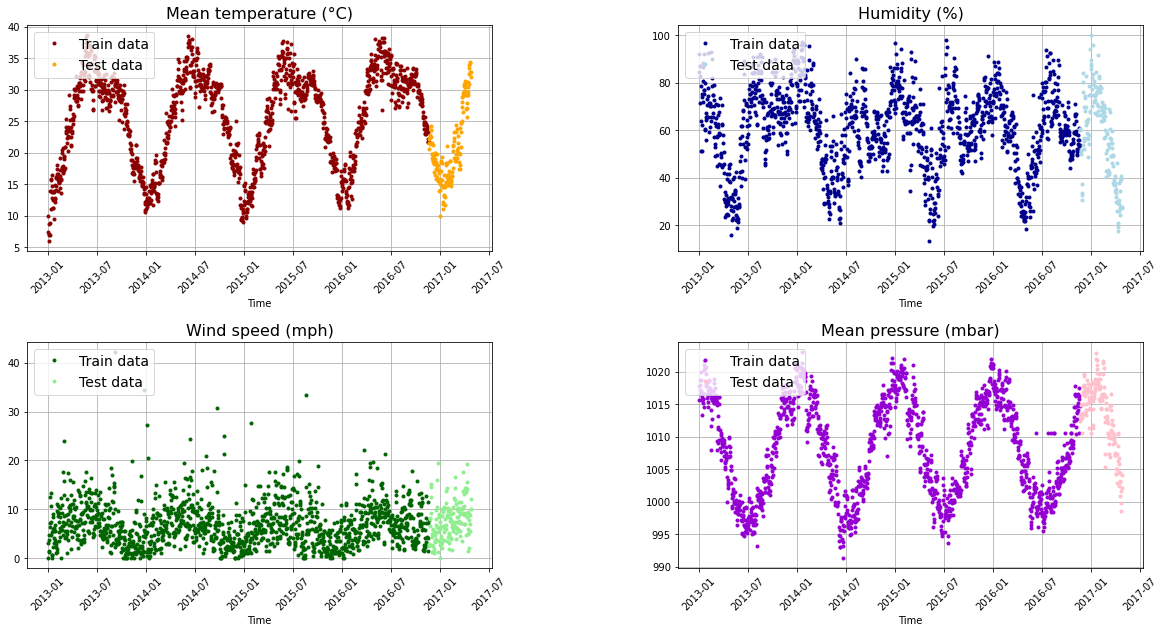

In [23]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,
                                             2,
                                             figsize=(20, 10),
                                             gridspec_kw={
                                                 'wspace': .4,
                                                 'hspace': .4
                                             })

helpers.plot_time_series(ax1,
                         train_df.index,
                         train_df["meantemp"],
                         "Mean temperature (°C)",
                         label='Train data',
                         c='darkred')
helpers.plot_time_series(ax1,
                         test_df.index,
                         test_df["meantemp"],
                         "Mean temperature (°C)",
                         label='Test data',
                         c='orange')
helpers.plot_time_series(ax2,
                         train_df.index,
                         train_df["humidity"],
                         "Humidity (%)",
                         label='Train data',
                         c='darkblue')
helpers.plot_time_series(ax2,
                         test_df.index,
                         test_df["humidity"],
                         "Humidity (%)",
                         label='Test data',
                         c='lightblue')
helpers.plot_time_series(ax3,
                         train_df.index,
                         train_df["wind_speed"],
                         "Wind speed (mph)",
                         label='Train data',
                         c='darkgreen')
helpers.plot_time_series(ax3,
                         test_df.index,
                         test_df["wind_speed"],
                         "Wind speed (mph)",
                         label='Test data',
                         c='lightgreen')
helpers.plot_time_series(ax4,
                         train_df.index,
                         train_df["meanpressure"],
                         "Mean pressure (mbar)",
                         label='Train data',
                         c='darkviolet')
helpers.plot_time_series(ax4,
                         test_df.index,
                         test_df["meanpressure"],
                         "Mean pressure (mbar)",
                         label='Test data',
                         c='pink')

# fig.savefig('./graphs/train_plus_test_data_fixed.png', facecolor='white')

## Correlation matrix

Text(0.5, 1.0, 'Correlation matrix')

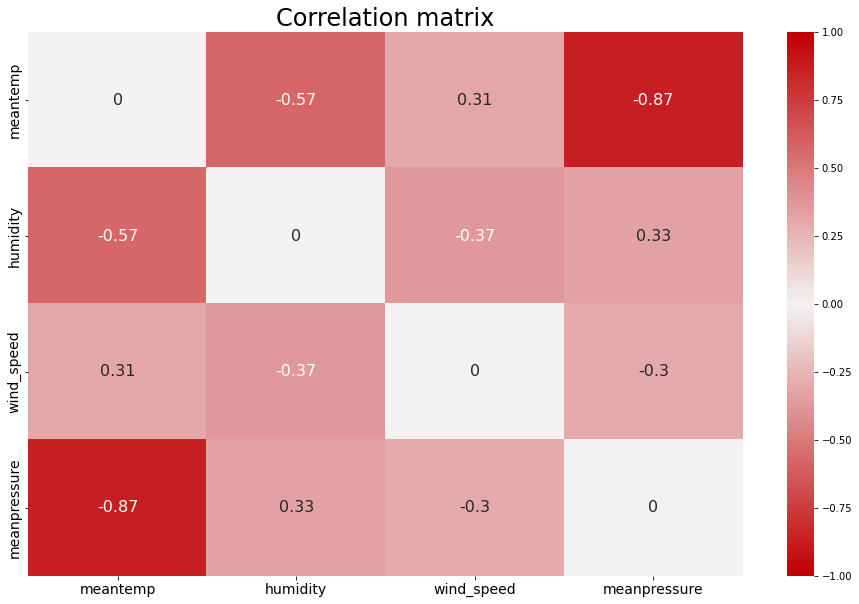

In [9]:
fig, ax = plt.subplots(figsize=(16, 10))
corr_mat = train_df.corr().replace(to_replace=1.0, value=0)
cmap = sns.diverging_palette(12, 12, s=100, l=40, as_cmap=True)
sns.heatmap(ax=ax,
            data=corr_mat,
            annot=True,
            center=0,
            vmin=-1,
            vmax=1,
            cmap=cmap,
            annot_kws={'size': 16})
ax.set_xticklabels(corr_mat.columns, size=14)
ax.set_yticklabels(corr_mat.columns, size=14)
ax.set_title("Correlation matrix", fontsize=24)

# fig.savefig('./graphs/correlation_matrix.png', facecolor='white')

# Preprocessing

## Normalize data

In [10]:
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[df_scaled.columns] = scaler.fit_transform(df[df.columns])
df_scaled.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,-2.073073,1.417103,-1.530010,0.960439
2013-01-02,-2.427167,1.858940,-0.869152,1.249557
2013-01-03,-2.458944,1.564382,-0.502502,1.367012
2013-01-04,-2.254659,0.641435,-1.256500,1.163725
2013-01-05,-2.617833,1.554564,-0.709482,1.073376


## Split data

In [11]:
df_size = len(df_scaled)
train_size = int(df_size * TRAIN_SIZE)
val_size = int(df_size * VAL_SIZE)
train_df = df_scaled[:train_size]
val_df = df_scaled[train_size:train_size + val_size]
test_df = df_scaled[train_size + val_size:]

In [12]:
num_features = df.shape[1]

## Windowing data

In [13]:
WINDOW_SIZE = 7
HORIZON = 1

In [14]:
single_step_window = helpers.WindowGenerator(input_width=WINDOW_SIZE,
                                             label_width=HORIZON,
                                             shift=HORIZON,
                                             train_df=train_df,
                                             val_df=val_df,
                                             test_df=test_df)
wide_window = helpers.WindowGenerator(input_width=30,
                                      label_width=30,
                                      shift=HORIZON,
                                      train_df=train_df,
                                      val_df=val_df,
                                      test_df=test_df)

In [15]:
print(single_step_window)
print('-'*30)
print(wide_window)

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): None
------------------------------
Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): None


# Training

In [16]:
loss = tf.keras.losses.MeanSquaredError()
metrics = [tf.keras.metrics.MeanAbsoluteError()]

## Baseline

In [29]:
baseline = helpers.Baseline()
baseline.compile(loss=loss, metrics=metrics)

In [30]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

5/5 [==============================] - 0s 3ms/step - loss: 0.2532 - mean_absolute_error: 0.3177


In [34]:
baseline.predict(single_step_window.test).shape

(152, 1, 4)

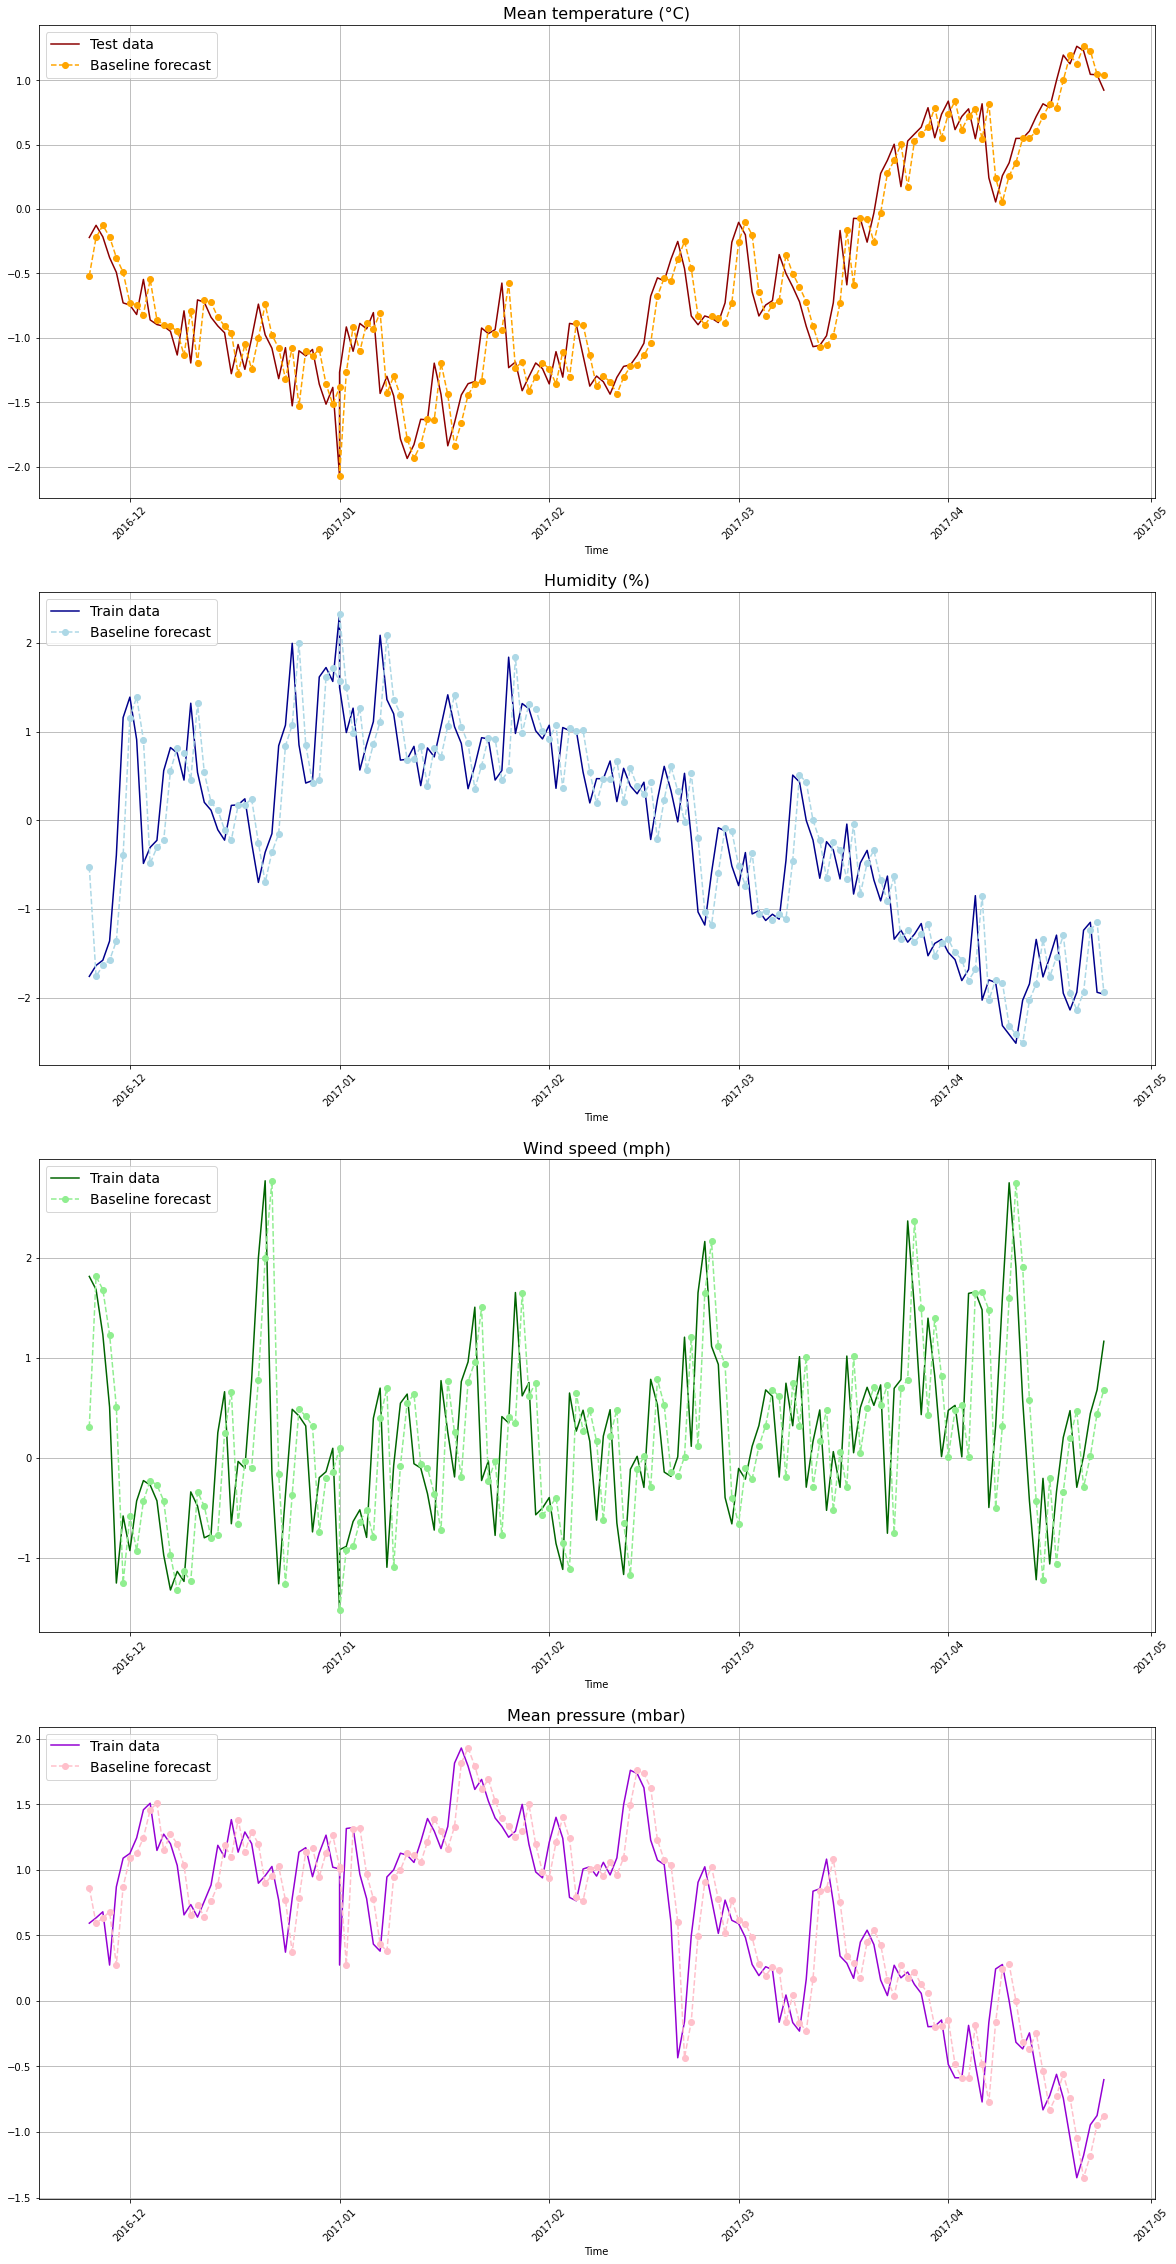

In [35]:
single_step_window.plot_ts(baseline, "Baseline forecast")

## Dense

In [36]:
dense = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -WINDOW_SIZE:, :]),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.GlobalAvgPool1D(keepdims=True),
    tf.keras.layers.Dense(units=num_features),
])

In [37]:
history = helpers.compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/100
40/40 [==============================] - 1s 9ms/step - loss: 0.6448 - mean_absolute_error: 0.6205 - val_loss: 0.3165 - val_mean_absolute_error: 0.4214
Epoch 2/100
40/40 [==============================] - 0s 5ms/step - loss: 0.3710 - mean_absolute_error: 0.4198 - val_loss: 0.2569 - val_mean_absolute_error: 0.3689
Epoch 3/100
40/40 [==============================] - 0s 6ms/step - loss: 0.3572 - mean_absolute_error: 0.4078 - val_loss: 0.2572 - val_mean_absolute_error: 0.3673
Epoch 4/100
40/40 [==============================] - 0s 7ms/step - loss: 0.3552 - mean_absolute_error: 0.4034 - val_loss: 0.2584 - val_mean_absolute_error: 0.3685
Epoch 5/100
40/40 [==============================] - 0s 6ms/step - loss: 0.3529 - mean_absolute_error: 0.4025 - val_loss: 0.2613 - val_mean_absolute_error: 0.3698
Epoch 6/100
40/40 [==============================] - 0s 7ms/step - loss: 0.3520 - mean_absolute_error: 0.4015 - val_loss: 0.2571 - val_mean_absolute_error: 0.3649
Epoch 7/100
40/40 [===

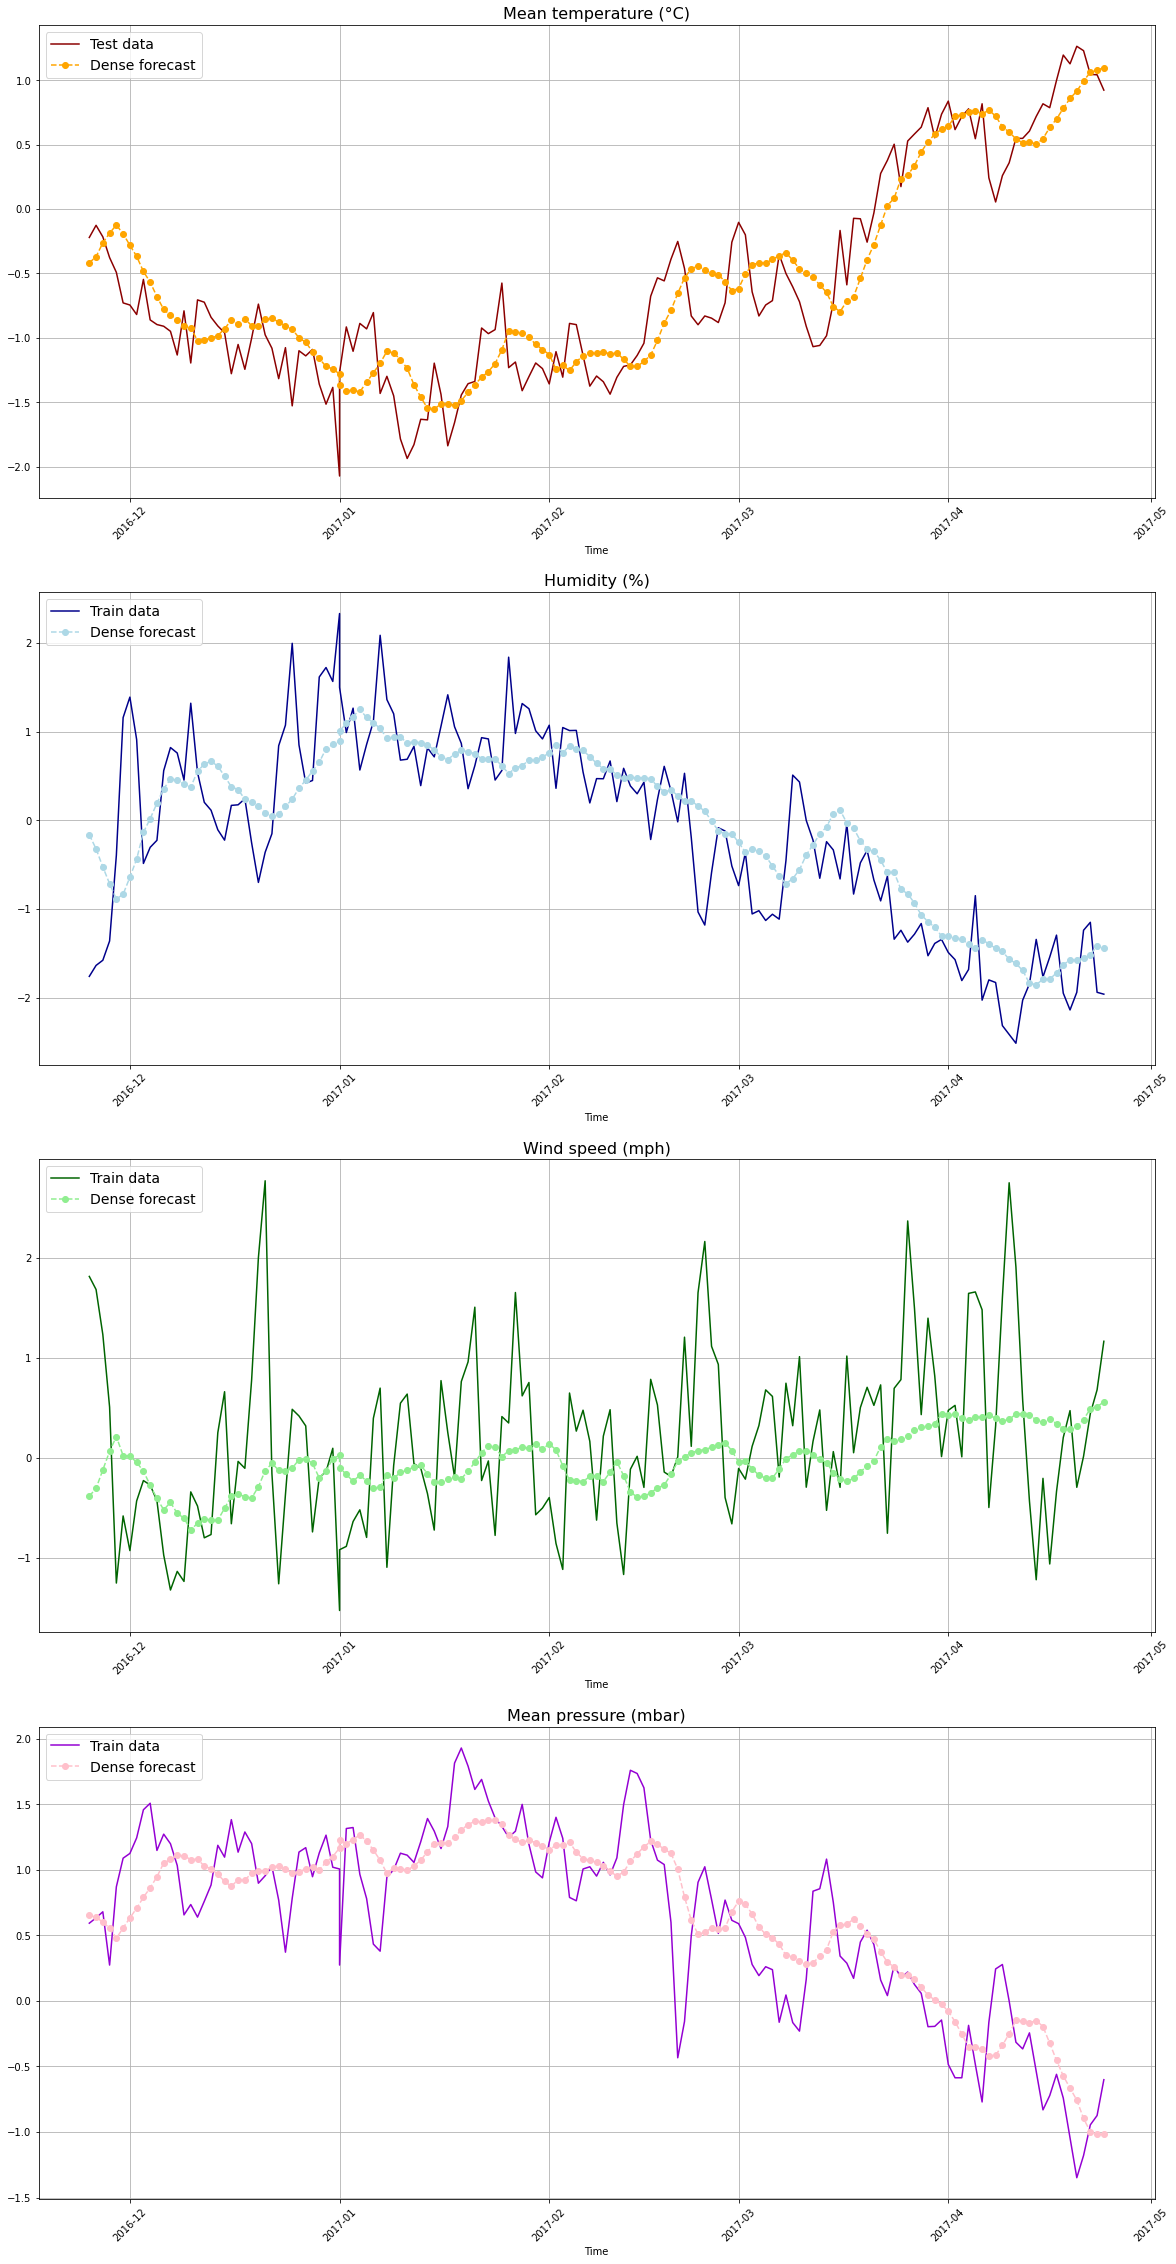

In [38]:
single_step_window.plot_ts(dense, title="Dense forecast")

## LSTM

In [39]:
%%time
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.Dense(units=num_features)
])

history = helpers.compile_and_fit(lstm_model, single_step_window)

val_performance['LSTM'] = lstm_model.evaluate(single_step_window.val)
performance['LSTM'] = lstm_model.evaluate(single_step_window.test, verbose=0)

Epoch 1/100
40/40 [==============================] - 6s 33ms/step - loss: 0.6677 - mean_absolute_error: 0.6299 - val_loss: 0.3707 - val_mean_absolute_error: 0.4646
Epoch 2/100
40/40 [==============================] - 1s 12ms/step - loss: 0.3971 - mean_absolute_error: 0.4425 - val_loss: 0.2936 - val_mean_absolute_error: 0.4059
Epoch 3/100
40/40 [==============================] - 1s 14ms/step - loss: 0.3777 - mean_absolute_error: 0.4275 - val_loss: 0.2849 - val_mean_absolute_error: 0.3954
Epoch 4/100
40/40 [==============================] - 1s 14ms/step - loss: 0.3703 - mean_absolute_error: 0.4206 - val_loss: 0.2779 - val_mean_absolute_error: 0.3870
Epoch 5/100
40/40 [==============================] - 1s 13ms/step - loss: 0.3638 - mean_absolute_error: 0.4147 - val_loss: 0.2719 - val_mean_absolute_error: 0.3802
Epoch 6/100
40/40 [==============================] - 1s 12ms/step - loss: 0.3594 - mean_absolute_error: 0.4106 - val_loss: 0.2692 - val_mean_absolute_error: 0.3768
Epoch 7/100
40/4

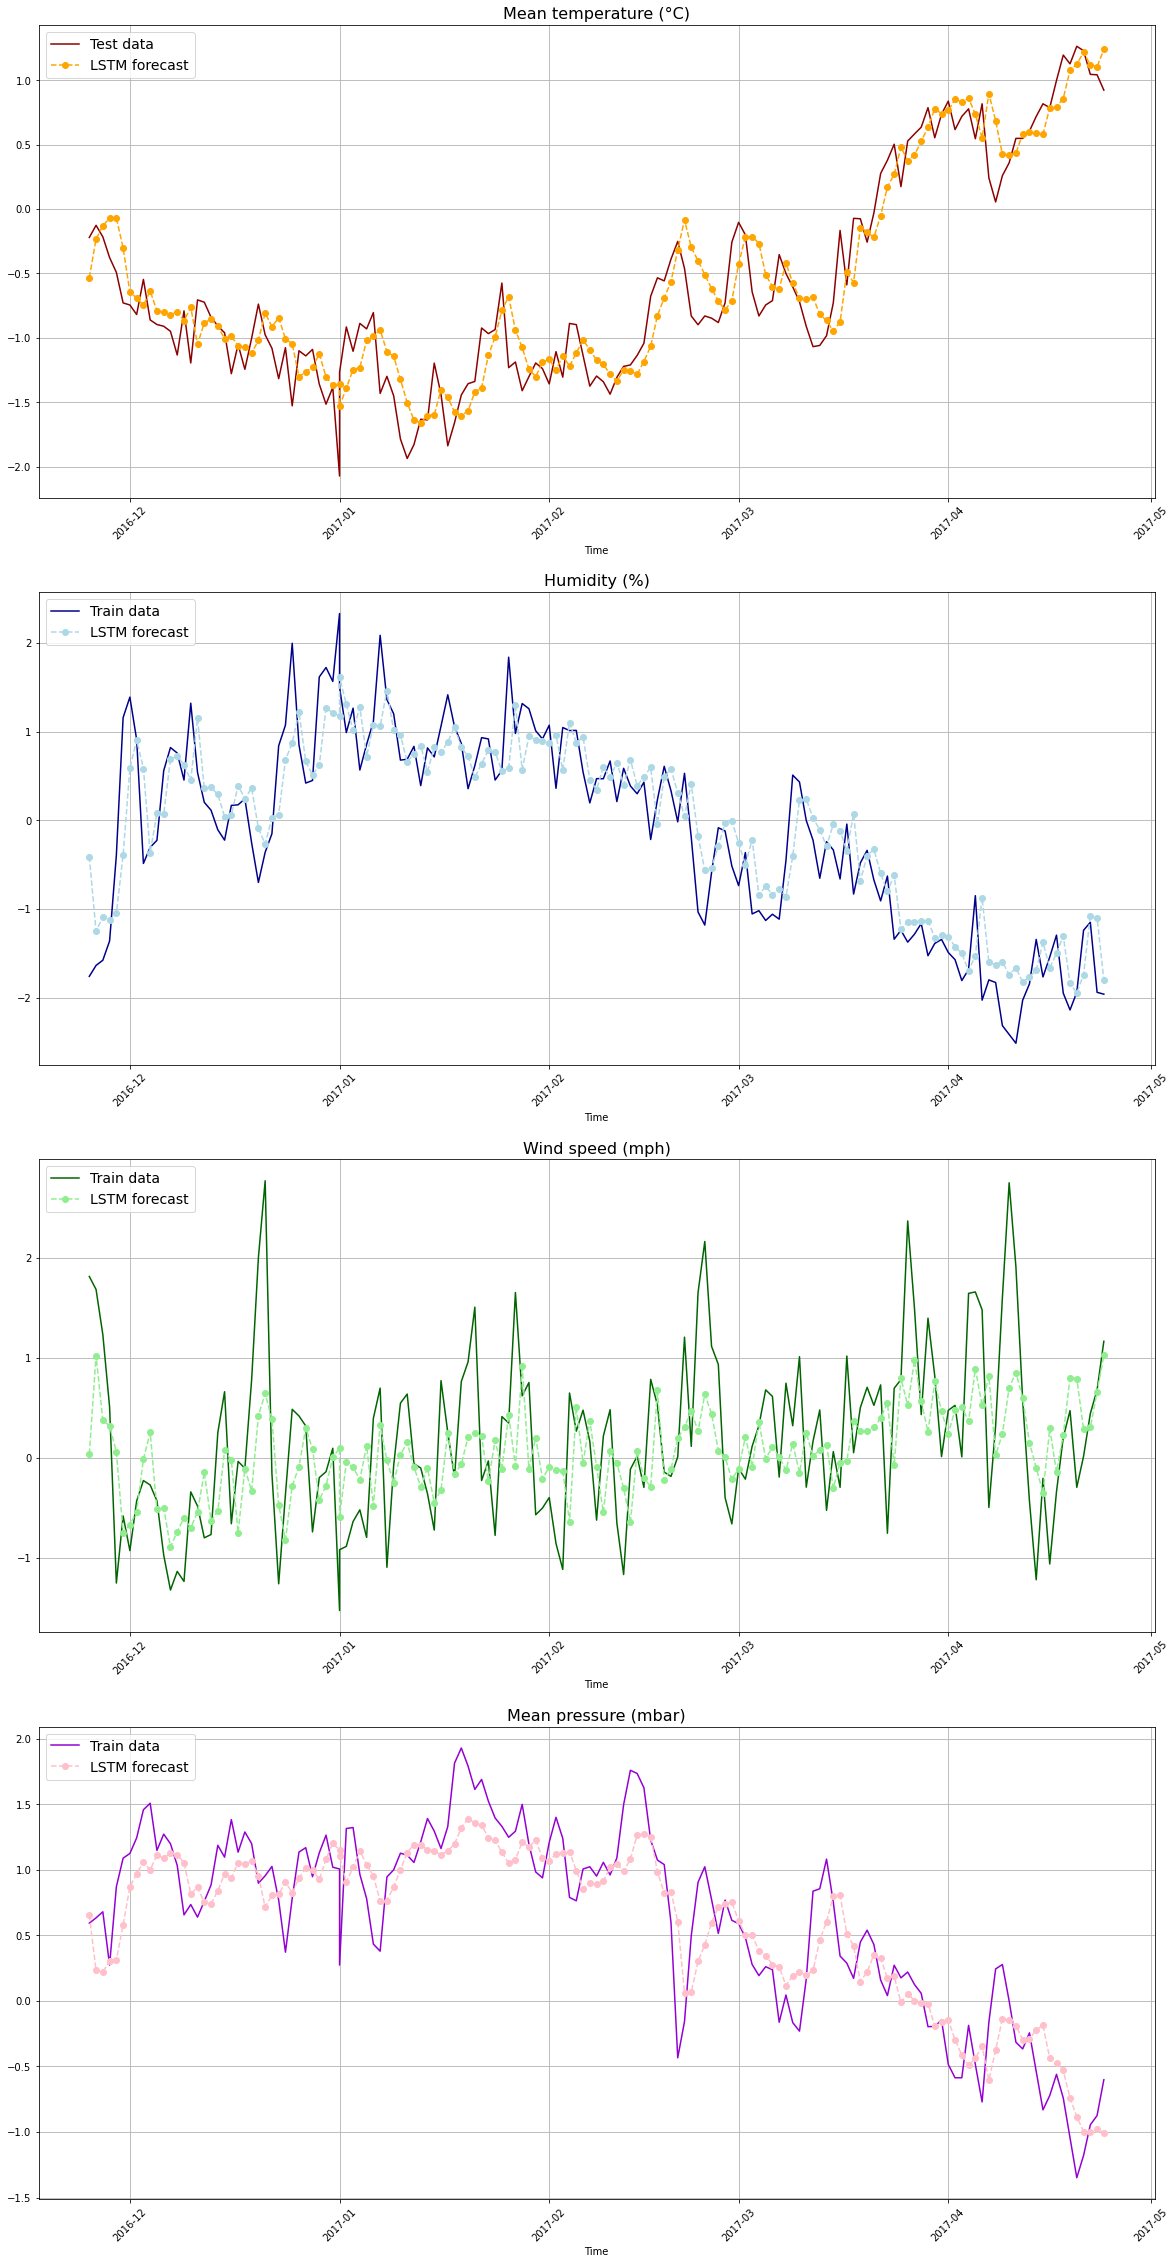

In [40]:
single_step_window.plot_ts(lstm_model, title="LSTM forecast")

## Residual LSTM

In [31]:
%%time
residual_lstm = helpers.CustomResidualWrapper(
    tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = helpers.compile_and_fit(residual_lstm, single_step_window)

val_performance['Residual LSTM'] = residual_lstm.evaluate(single_step_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(single_step_window.test, verbose=0)

Epoch 1/100
40/40 [==============================] - 4s 26ms/step - loss: 0.3956 - mean_absolute_error: 0.3642 - val_loss: 0.2521 - val_mean_absolute_error: 0.3170
Epoch 2/100
40/40 [==============================] - 0s 9ms/step - loss: 0.3930 - mean_absolute_error: 0.3633 - val_loss: 0.2489 - val_mean_absolute_error: 0.3155
Epoch 3/100
40/40 [==============================] - 0s 9ms/step - loss: 0.3850 - mean_absolute_error: 0.3605 - val_loss: 0.2420 - val_mean_absolute_error: 0.3120
Epoch 4/100
40/40 [==============================] - 0s 8ms/step - loss: 0.3639 - mean_absolute_error: 0.3540 - val_loss: 0.2271 - val_mean_absolute_error: 0.3052
Epoch 5/100
40/40 [==============================] - 0s 9ms/step - loss: 0.3276 - mean_absolute_error: 0.3447 - val_loss: 0.2157 - val_mean_absolute_error: 0.3068
Epoch 6/100
40/40 [==============================] - 0s 9ms/step - loss: 0.3081 - mean_absolute_error: 0.3410 - val_loss: 0.2143 - val_mean_absolute_error: 0.3051
Epoch 7/100
40/40 [==

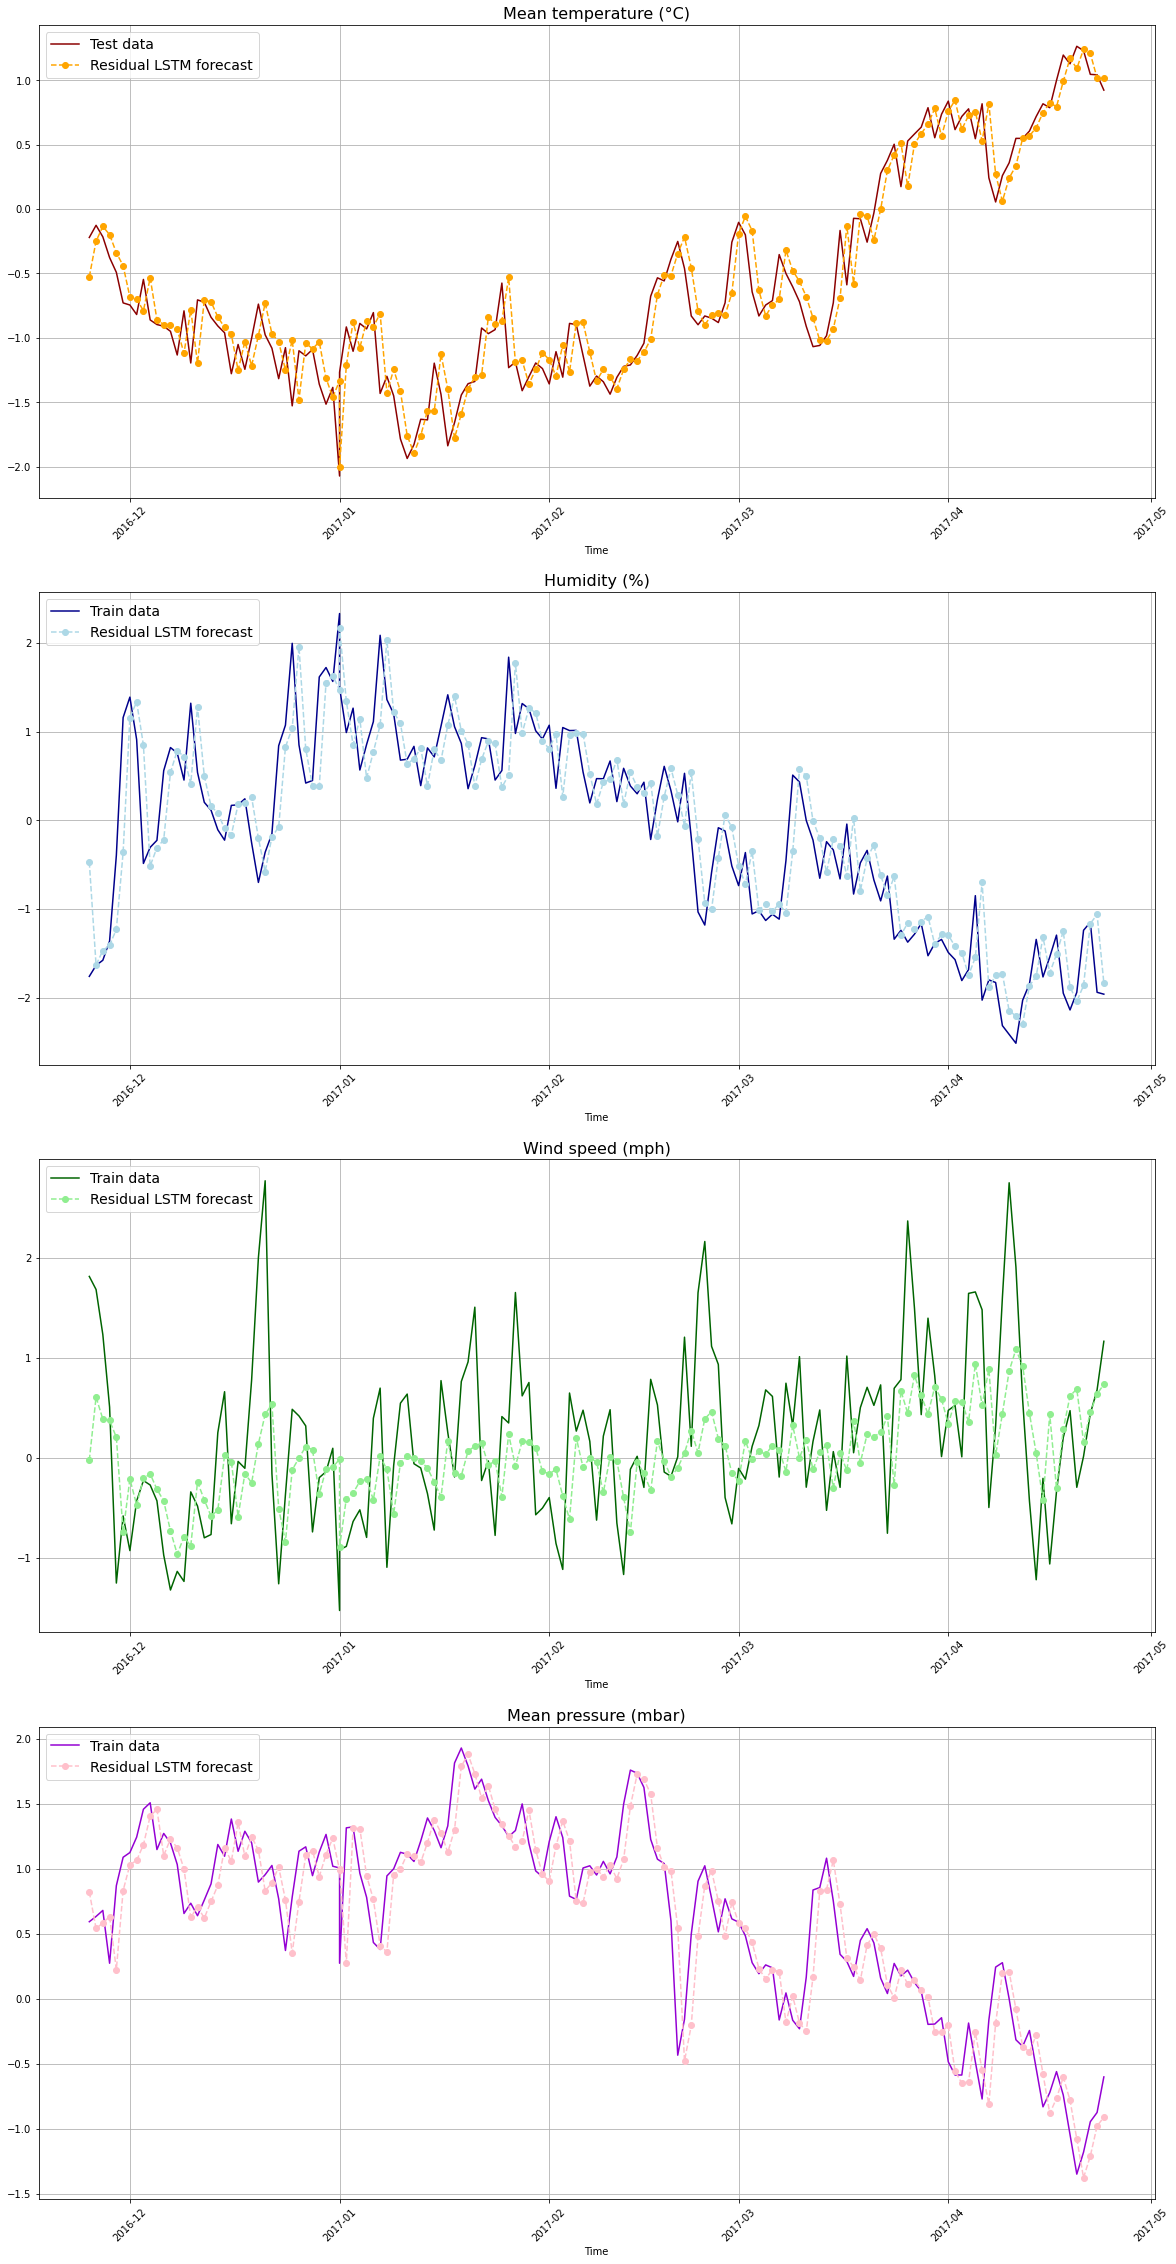

In [42]:
single_step_window.plot_ts(residual_lstm, title="Residual LSTM forecast")

## Conv1D

In [43]:
CONV_WIDTH = 3
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(128,
                           kernel_size=CONV_WIDTH,
                           padding="causal",
                           activation="relu"),
    tf.keras.layers.Conv1D(128,
                           kernel_size=CONV_WIDTH,
                           padding="causal",
                           activation="relu"),
    tf.keras.layers.GlobalAvgPool1D(keepdims=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(num_features)
])

history = helpers.compile_and_fit(conv_model, single_step_window)

val_performance['Conv'] = conv_model.evaluate(single_step_window.val)
performance['Conv'] = conv_model.evaluate(single_step_window.test, verbose=0)

Epoch 1/100
40/40 [==============================] - 1s 13ms/step - loss: 0.5125 - mean_absolute_error: 0.5213 - val_loss: 0.2991 - val_mean_absolute_error: 0.4098
Epoch 2/100
40/40 [==============================] - 0s 11ms/step - loss: 0.3917 - mean_absolute_error: 0.4392 - val_loss: 0.2760 - val_mean_absolute_error: 0.3795
Epoch 3/100
40/40 [==============================] - 0s 9ms/step - loss: 0.3771 - mean_absolute_error: 0.4241 - val_loss: 0.2722 - val_mean_absolute_error: 0.3772
Epoch 4/100
40/40 [==============================] - 0s 9ms/step - loss: 0.3648 - mean_absolute_error: 0.4159 - val_loss: 0.2755 - val_mean_absolute_error: 0.3843
Epoch 5/100
40/40 [==============================] - 0s 9ms/step - loss: 0.3561 - mean_absolute_error: 0.4104 - val_loss: 0.2765 - val_mean_absolute_error: 0.3834
Epoch 6/100
40/40 [==============================] - 0s 10ms/step - loss: 0.3458 - mean_absolute_error: 0.4044 - val_loss: 0.2843 - val_mean_absolute_error: 0.3894
Epoch 7/100
40/40 [

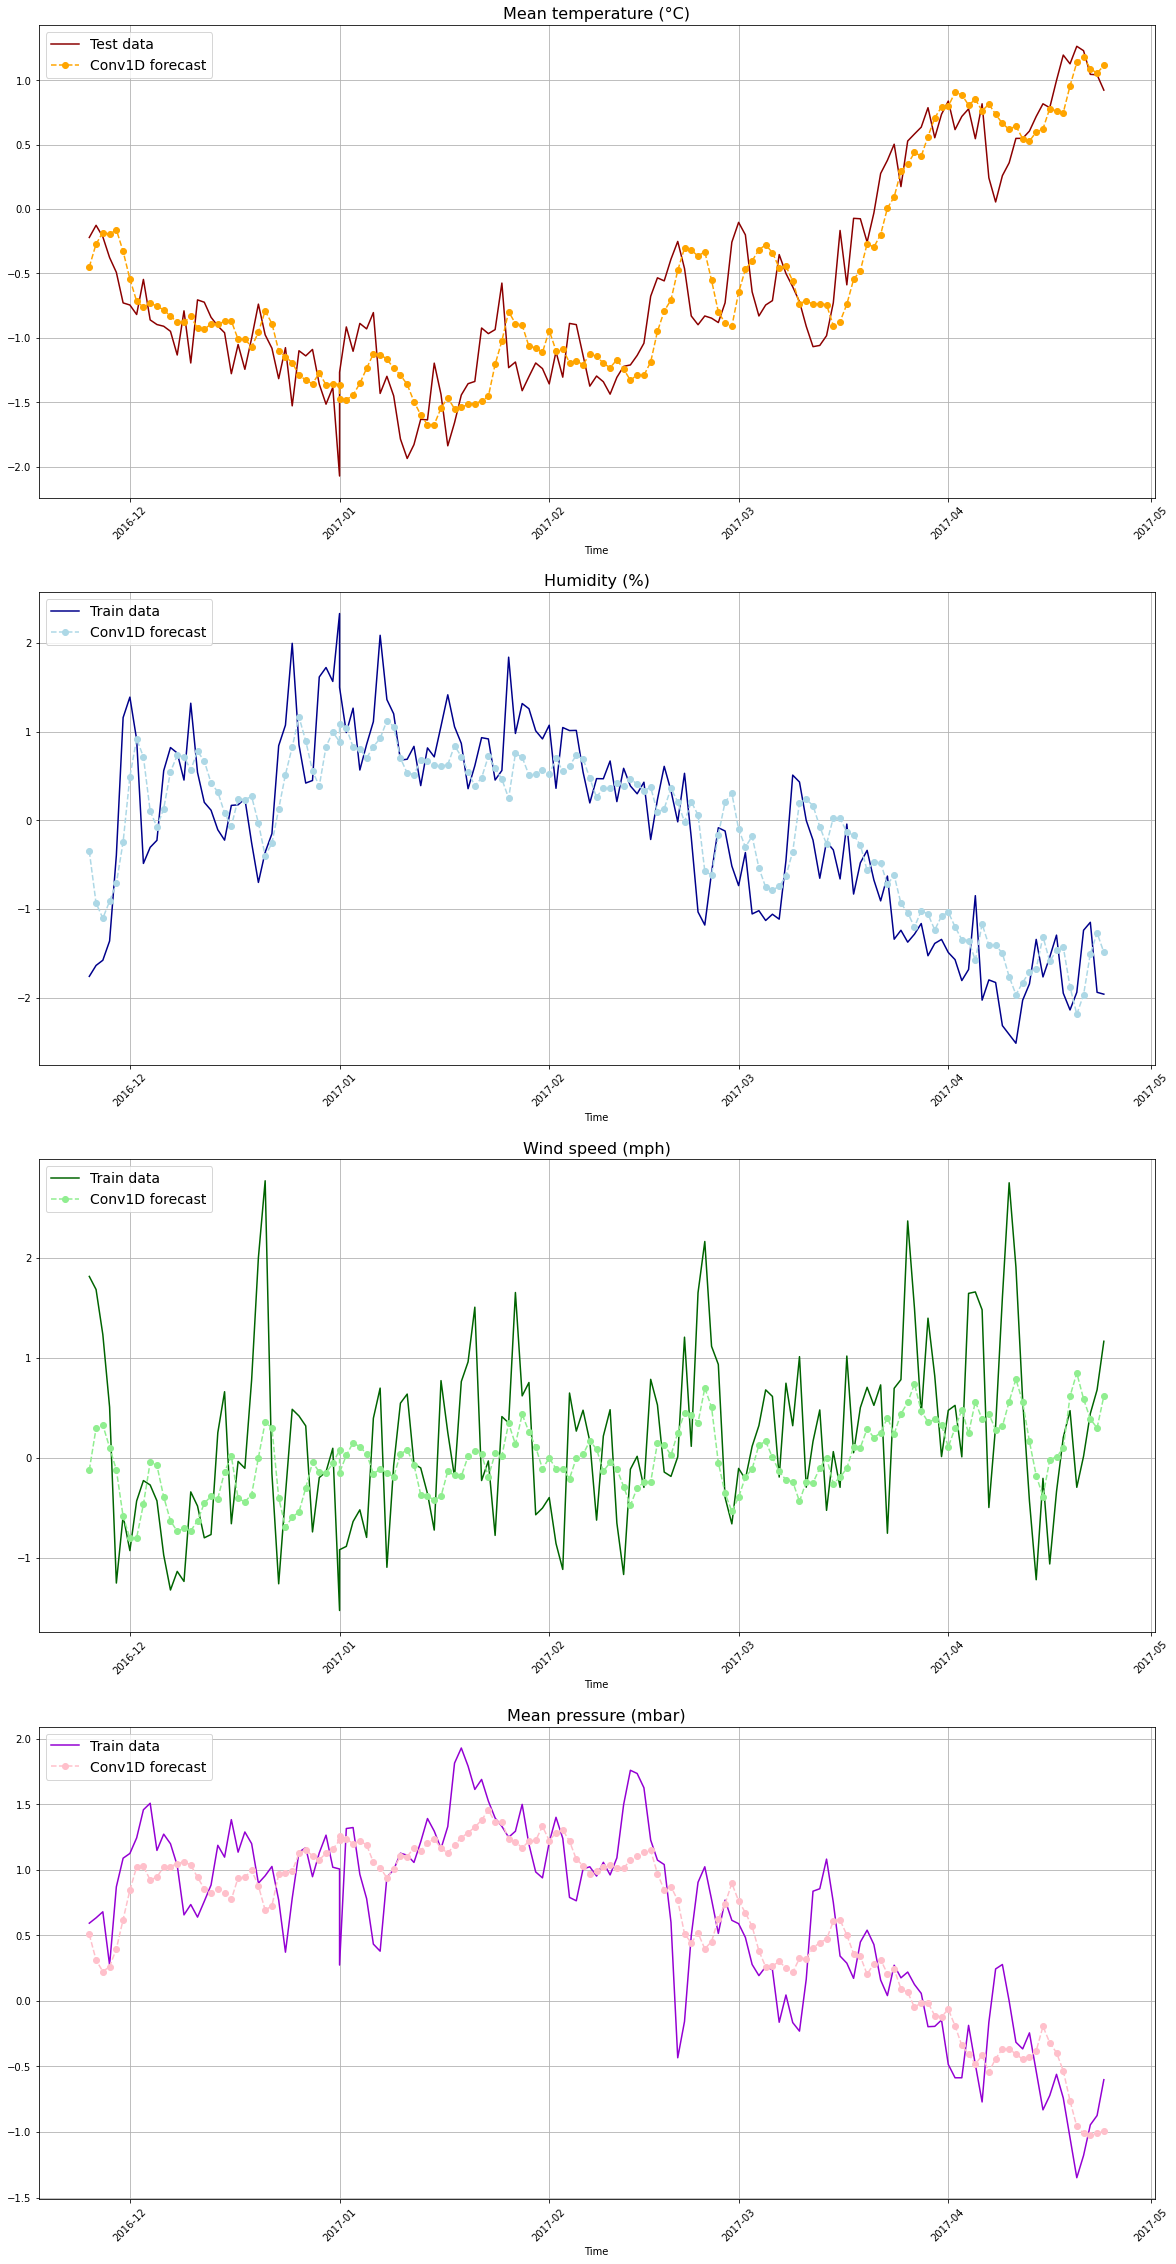

In [44]:
single_step_window.plot_ts(conv_model, title="Conv1D forecast")

# Evaluation

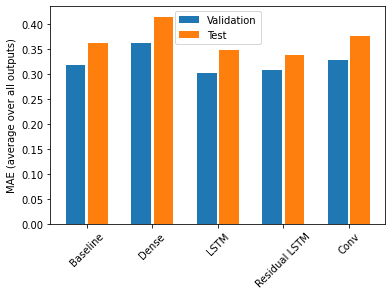

In [45]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index(metric_name)
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [46]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.3616
Dense          : 0.4142
LSTM           : 0.3472
Residual LSTM  : 0.3386
Conv           : 0.3756


# Save best model

In [47]:
residual_lstm.save('model/residual_lstm')

In [17]:
reloaded_model = tf.keras.models.load_model('model/residual_lstm')

In [49]:
reloaded_model.evaluate(single_step_window.test)

5/5 [==============================] - 0s 5ms/step - loss: 0.2374 - mean_absolute_error: 0.3386


[0.23738208413124084, 0.3386436998844147]

# Prediction with different windows

## window = 1->30, horizon = 1

In [50]:
%%time
val_perf = []
test_perf = []
for i in range(1,31):
    w = helpers.WindowGenerator(input_width=i,
                                label_width=HORIZON,
                                shift=HORIZON,
                                train_df=train_df,
                                val_df=val_df,
                                test_df=test_df)
    residual_lstm = helpers.CustomResidualWrapper(
      tf.keras.models.Sequential([
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(
            num_features,
            # The predicted deltas should start small.
            # Therefore, initialize the output layer with zeros.
            kernel_initializer=tf.initializers.zeros())
      ])
    )

    history = helpers.compile_and_fit(residual_lstm, w)

    val_performance['Residual LSTM'] = residual_lstm.evaluate(w.val)
    performance['Residual LSTM'] = residual_lstm.evaluate(w.test, verbose=0)

    _ = helpers.compile_and_fit(residual_lstm, w, patience=15)

    val_perf.append(residual_lstm.evaluate(w.val))
    test_perf.append(residual_lstm.evaluate(w.test, verbose=0))

Epoch 1/100
40/40 [==============================] - 5s 30ms/step - loss: 0.3938 - mean_absolute_error: 0.3640 - val_loss: 0.2479 - val_mean_absolute_error: 0.3158
Epoch 2/100
40/40 [==============================] - 0s 8ms/step - loss: 0.3845 - mean_absolute_error: 0.3607 - val_loss: 0.2367 - val_mean_absolute_error: 0.3099
Epoch 3/100
40/40 [==============================] - 0s 8ms/step - loss: 0.3511 - mean_absolute_error: 0.3509 - val_loss: 0.2155 - val_mean_absolute_error: 0.3024
Epoch 4/100
40/40 [==============================] - 0s 9ms/step - loss: 0.3104 - mean_absolute_error: 0.3396 - val_loss: 0.2076 - val_mean_absolute_error: 0.3023
Epoch 5/100
40/40 [==============================] - 0s 9ms/step - loss: 0.2972 - mean_absolute_error: 0.3372 - val_loss: 0.2088 - val_mean_absolute_error: 0.3041
Epoch 6/100
40/40 [==============================] - 0s 8ms/step - loss: 0.2952 - mean_absolute_error: 0.3382 - val_loss: 0.2089 - val_mean_absolute_error: 0.3044
Epoch 7/100
40/40 [==

In [51]:
val_mae = [v[1] for v in val_perf]
test_mae = [v[1] for v in test_perf]

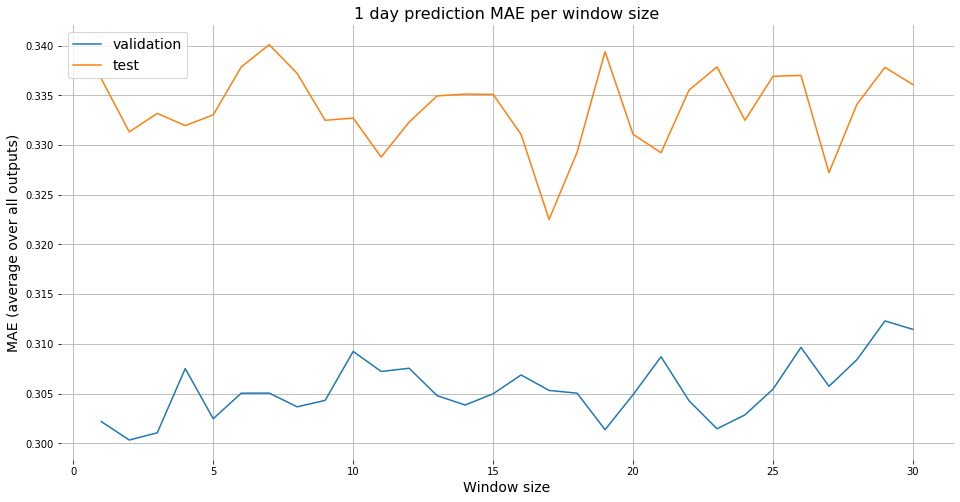

In [53]:
x = np.linspace(1,30,30)
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(x, val_mae, label='validation')
ax.plot(x, test_mae, label='test')
ax.grid(True)
ax.legend(fontsize=14);
ax.set_title('1 day prediction MAE per window size', fontsize=16)
ax.set_frame_on(False)
ax.set_xlabel('Window size', fontsize=14)
ax.set_ylabel('MAE (average over all outputs)', fontsize=14)

fig.savefig('graphs/window_size_benchmark.png', facecolor='white')

## window = 1->30, horizon = 7

Total window size: 14
Input indices: [0 1 2 3 4 5 6]
Label indices: [ 7  8  9 10 11 12 13]
Label column name(s): None

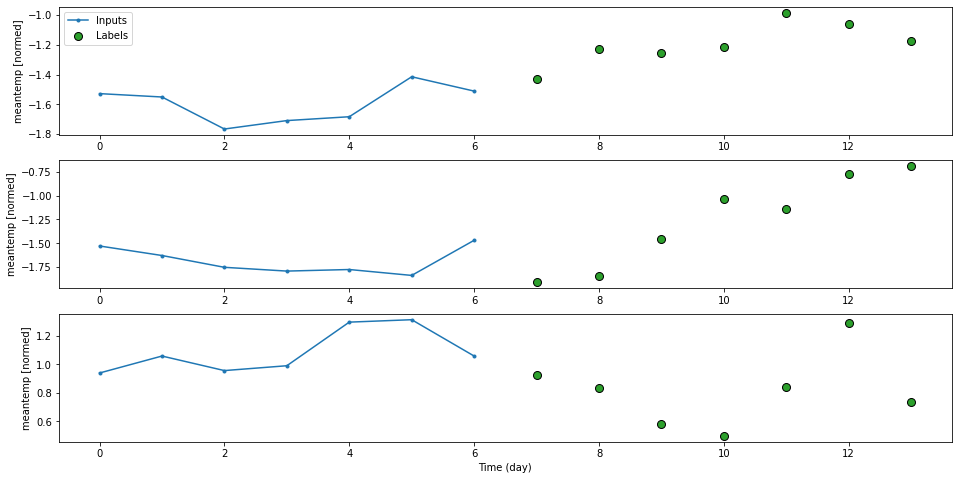

In [32]:
HORIZON = 7
multi_window = helpers.WindowGenerator(input_width=WINDOW_SIZE,
                                       label_width=HORIZON,
                                       shift=HORIZON,
                                       train_df=train_df,
                                       val_df=val_df,
                                       test_df=test_df)

multi_window.plot()
multi_window

In [96]:
%%time
val_perf = []
test_perf = []
for i in range(1,31):
    w = helpers.WindowGenerator(input_width=i,
                                label_width=HORIZON,
                                shift=HORIZON,
                                train_df=train_df,
                                val_df=val_df,
                                test_df=test_df)
    multi_residual_lstm = helpers.CustomResidualWrapper(
        tf.keras.models.Sequential([
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(HORIZON*num_features, kernel_initializer=tf.initializers.zeros()),
        tf.keras.layers.Reshape([HORIZON, num_features])
    ]))

    history = helpers.compile_and_fit(multi_residual_lstm, w)

    val_performance['Residual LSTM'] = multi_residual_lstm.evaluate(w.val)
    performance['Residual LSTM'] = multi_residual_lstm.evaluate(w.test, verbose=0)

    _ = helpers.compile_and_fit(multi_residual_lstm, w, patience=15)

    val_perf.append(multi_residual_lstm.evaluate(w.val))
    test_perf.append(multi_residual_lstm.evaluate(w.test, verbose=0))

Epoch 1/100
40/40 [==============================] - 5s 28ms/step - loss: 0.6279 - mean_absolute_error: 0.5153 - val_loss: 0.4174 - val_mean_absolute_error: 0.4475
Epoch 2/100
40/40 [==============================] - 0s 9ms/step - loss: 0.6058 - mean_absolute_error: 0.5084 - val_loss: 0.3846 - val_mean_absolute_error: 0.4323
Epoch 3/100
40/40 [==============================] - 0s 7ms/step - loss: 0.5390 - mean_absolute_error: 0.4901 - val_loss: 0.3390 - val_mean_absolute_error: 0.4164
Epoch 4/100
40/40 [==============================] - 0s 9ms/step - loss: 0.4695 - mean_absolute_error: 0.4687 - val_loss: 0.3317 - val_mean_absolute_error: 0.4195
Epoch 5/100
40/40 [==============================] - 0s 8ms/step - loss: 0.4456 - mean_absolute_error: 0.4614 - val_loss: 0.3297 - val_mean_absolute_error: 0.4197
Epoch 6/100
40/40 [==============================] - 0s 9ms/step - loss: 0.4392 - mean_absolute_error: 0.4601 - val_loss: 0.3232 - val_mean_absolute_error: 0.4153
Epoch 7/100
40/40 [==

In [97]:
val_mae = [v[1] for v in val_perf]
test_mae = [v[1] for v in test_perf]

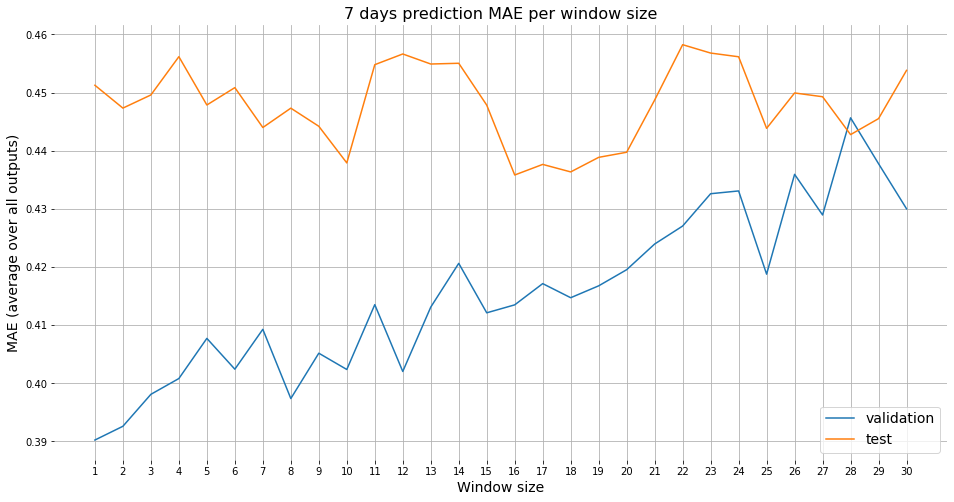

In [98]:
x = np.linspace(1,30,30)
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(x, val_mae, label='validation')
ax.plot(x, test_mae, label='test')
ax.grid(True)
ax.legend(fontsize=14);
ax.set_title('7 days prediction MAE per window size', fontsize=16)
ax.set_frame_on(False)
ax.set_xlabel('Window size', fontsize=14)
ax.set_ylabel('MAE (average over all outputs)', fontsize=14)
ax.set_xticks(x);

fig.savefig('graphs/window_size_benchmark_2.png', facecolor='white')

# Make predictions on the future

Total window size: 23
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Label indices: [16 17 18 19 20 21 22]
Label column name(s): None

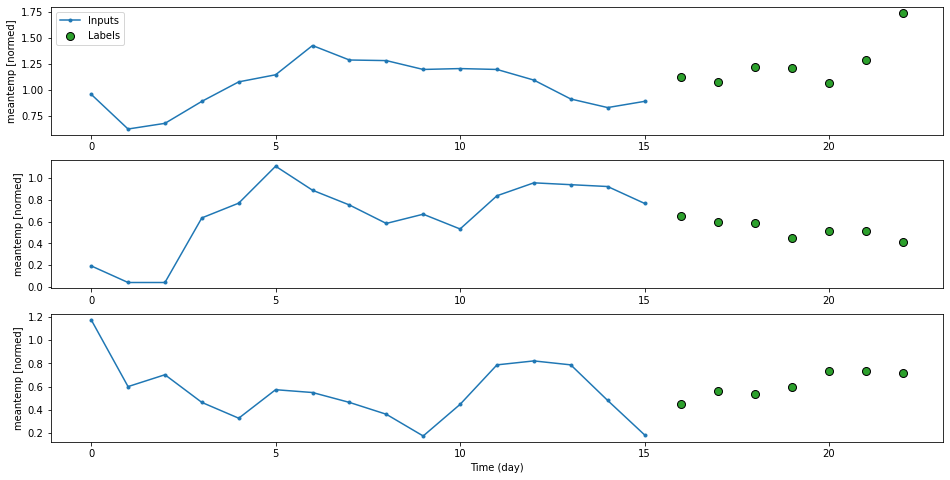

In [99]:
WINDOW_SIZE = 16
HORIZON = 7
multi_window = helpers.WindowGenerator(input_width=WINDOW_SIZE,
                                       label_width=HORIZON,
                                       shift=HORIZON,
                                       train_df=train_df,
                                       val_df=val_df,
                                       test_df=test_df)

multi_window.plot()
multi_window

In [100]:
%%time
multi_residual_lstm = helpers.CustomResidualWrapper(
    tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(HORIZON*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([HORIZON, num_features])
]))
helpers.compile_and_fit(multi_residual_lstm, multi_window)

Epoch 1/100
39/39 [==============================] - 4s 26ms/step - loss: 0.6263 - mean_absolute_error: 0.5133 - val_loss: 0.4392 - val_mean_absolute_error: 0.4556
Epoch 2/100
39/39 [==============================] - 0s 10ms/step - loss: 0.6213 - mean_absolute_error: 0.5104 - val_loss: 0.4349 - val_mean_absolute_error: 0.4533
Epoch 3/100
39/39 [==============================] - 0s 9ms/step - loss: 0.6135 - mean_absolute_error: 0.5069 - val_loss: 0.4282 - val_mean_absolute_error: 0.4506
Epoch 4/100
39/39 [==============================] - 0s 10ms/step - loss: 0.5938 - mean_absolute_error: 0.4996 - val_loss: 0.4086 - val_mean_absolute_error: 0.4439
Epoch 5/100
39/39 [==============================] - 0s 10ms/step - loss: 0.5419 - mean_absolute_error: 0.4837 - val_loss: 0.3600 - val_mean_absolute_error: 0.4247
Epoch 6/100
39/39 [==============================] - 0s 9ms/step - loss: 0.4625 - mean_absolute_error: 0.4574 - val_loss: 0.3368 - val_mean_absolute_error: 0.4223
Epoch 7/100
39/39 

In [101]:
WINDOW_SIZE, HORIZON

(16, 7)

In [102]:
multi_residual_lstm.summary()

Model: "custom_residual_wrapper_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_45 (Sequential)  (None, 7, 4)              13980     
                                                                 
Total params: 13,980
Trainable params: 13,980
Non-trainable params: 0
_________________________________________________________________


In [103]:
multi_residual_lstm.layers[0].summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_90 (LSTM)              (None, 16, 32)            4736      
                                                                 
 lstm_91 (LSTM)              (None, 32)                8320      
                                                                 
 dense_45 (Dense)            (None, 28)                924       
                                                                 
 reshape_39 (Reshape)        (None, 7, 4)              0         
                                                                 
Total params: 13,980
Trainable params: 13,980
Non-trainable params: 0
_________________________________________________________________


In [104]:
def get_future_dates(start_date, horizon, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  horizon: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(horizon, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end date

In [105]:
last_timestep = df_scaled.index[-1]
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   horizon=HORIZON)
next_time_steps

array(['2017-04-25', '2017-04-26', '2017-04-27', '2017-04-28',
       '2017-04-29', '2017-04-30', '2017-05-01'], dtype='datetime64[D]')

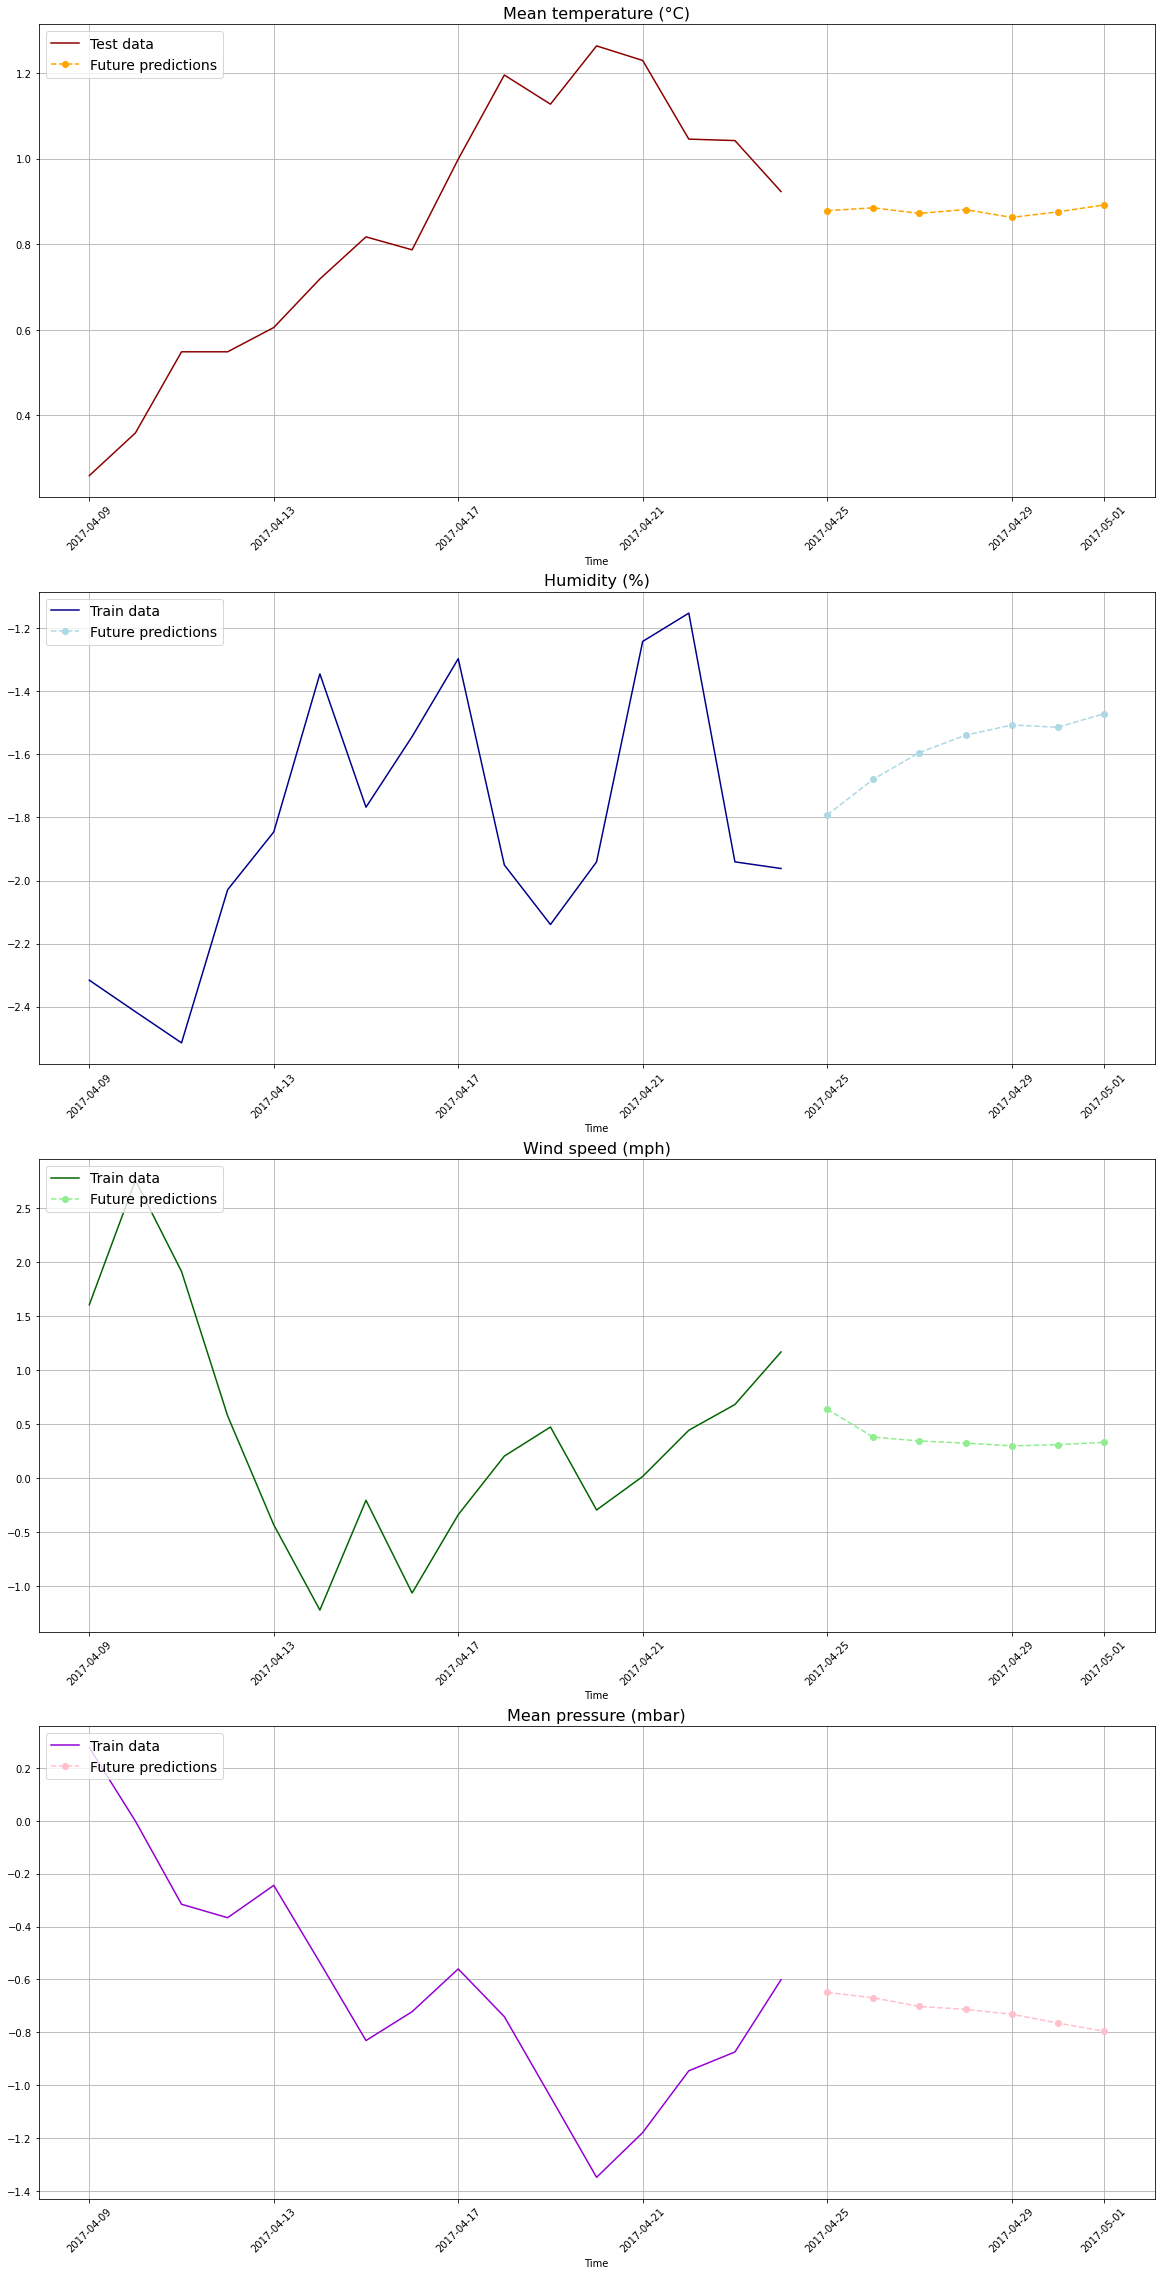

In [107]:
title = "Future predictions"
predictions = tf.squeeze(multi_residual_lstm.predict(tf.expand_dims(multi_window.test_df[-WINDOW_SIZE:], axis=0)))
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    4,
    1,
    figsize=(20, 40),
)

helpers.plot_time_series(ax1,
                  multi_window.test_df.index[-WINDOW_SIZE:],
                  multi_window.test_df["meantemp"][-WINDOW_SIZE:],
                  format="-",
                  label="Test data",
                  c='darkred')
helpers.plot_time_series(ax1,
                  next_time_steps,
                  predictions[:, multi_window.column_indices["meantemp"]],
                  "Mean temperature (°C)",
                  format="o--",
                  label=title,
                  c='orange')
helpers.plot_time_series(ax2,
                  multi_window.test_df.index[-WINDOW_SIZE:],
                  multi_window.test_df["humidity"][-WINDOW_SIZE:],
                  "Humidity (%)",
                  format="-",
                  label='Train data',
                  c='darkblue')
helpers.plot_time_series(ax2,
                  next_time_steps,
                  predictions[:, multi_window.column_indices["humidity"]],
                  "Humidity (%)",
                  format="o--",
                  label=title,
                  c='lightblue')
helpers.plot_time_series(ax3,
                  multi_window.test_df.index[-WINDOW_SIZE:],
                  multi_window.test_df["wind_speed"][-WINDOW_SIZE:],
                  "Wind speed (mph)",
                  format="-",
                  label='Train data',
                  c='darkgreen')
helpers.plot_time_series(ax3,
                  next_time_steps,
                  predictions[:, multi_window.column_indices["wind_speed"]],
                  "Wind speed (mph)",
                  format="o--",
                  label=title,
                  c='lightgreen')
helpers.plot_time_series(ax4,
                  multi_window.test_df.index[-WINDOW_SIZE:],
                  multi_window.test_df["meanpressure"][-WINDOW_SIZE:],
                  "Mean pressure (mbar)",
                  format="-",
                  label='Train data',
                  c='darkviolet')
helpers.plot_time_series(ax4,
                  next_time_steps,
                  predictions[:, multi_window.column_indices["meanpressure"]],
                  "Mean pressure (mbar)",
                  format="o--",
                  label=title,
                  c='pink')